In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
import joblib

sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
import os

filename = "student_pass_fail.csv"

try:
    df = pd.read_csv(filename)
    print(f"Loaded '{filename}' from current working directory.")
except FileNotFoundError:
    from google.colab import files
    print("File not found — please upload the CSV file now.")
    uploaded = files.upload()
    first_file = list(uploaded.keys())[0]
    df = pd.read_csv(first_file)
    print(f"Loaded uploaded file: {first_file}")

print("\nDataset shape:", df.shape)
df.head()


File not found — please upload the CSV file now.


Saving student_pass_fail.csv to student_pass_fail.csv
Loaded uploaded file: student_pass_fail.csv

Dataset shape: (200, 3)


,StudyHours,Attendance,Pass
0,6,65,0
1,19,42,0
2,14,58,0
3,10,59,0
4,7,71,0


In [3]:
required_cols = {"StudyHours", "Attendance", "Pass"}
present = set(df.columns)

print("Columns in dataset:", df.columns.tolist())

col_map = {}
if "Study Hours" in df.columns:
    col_map["Study Hours"] = "StudyHours"
if "StudyHours" not in df.columns and "study_hours" in df.columns:
    col_map["study_hours"] = "StudyHours"
if "Attendance" not in df.columns and "attendance" in df.columns:
    col_map["attendance"] = "Attendance"
if "Pass" not in df.columns and "pass" in df.columns:
    col_map["pass"] = "Pass"

if col_map:
    print("Renaming columns:", col_map)
    df = df.rename(columns=col_map)

if not required_cols.issubset(set(df.columns)):
    missing = required_cols - set(df.columns)
    raise ValueError(f"Dataset is missing required columns: {missing}. Please ensure CSV has StudyHours, Attendance, Pass.")

# Show counts & missing
print("\nMissing values per column:\n", df.isnull().sum())
print("\nPass value counts:\n", df['Pass'].value_counts())


Columns in dataset: ['StudyHours', 'Attendance', 'Pass']

Missing values per column:
 StudyHours    0
Attendance    0
Pass          0
dtype: int64

Pass value counts:
 Pass
0    157
1     43
Name: count, dtype: int64


In [4]:
if df['Pass'].nunique() < 2:
    print("WARNING: 'Pass' has only one class in the dataset. We'll create a balanced Pass label automatically.")
    # create a probabilistic pass score using StudyHours and Attendance and threshold at median
    score = (df['StudyHours'] / (df['StudyHours'].max() or 1)) * 0.6 + (df['Attendance'] / 100) * 0.4
    df['Pass'] = (score > score.median()).astype(int)
    print("New Pass distribution:\n", df['Pass'].value_counts())
else:
    print("'Pass' already contains multiple classes — good.")


'Pass' already contains multiple classes — good.


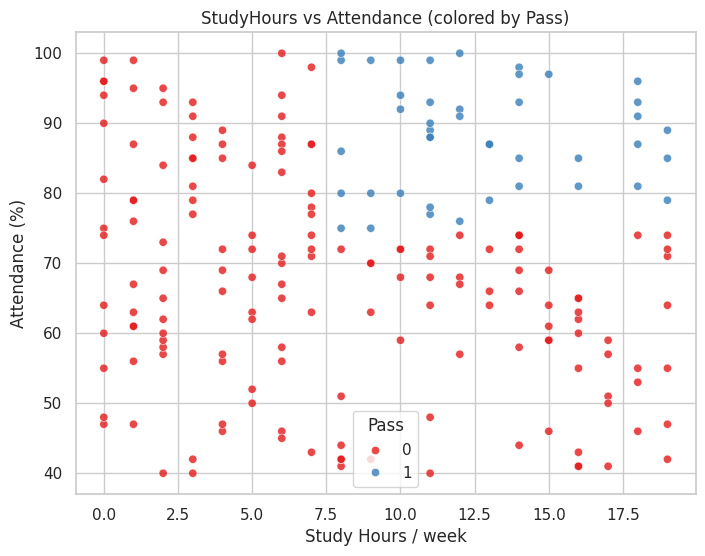

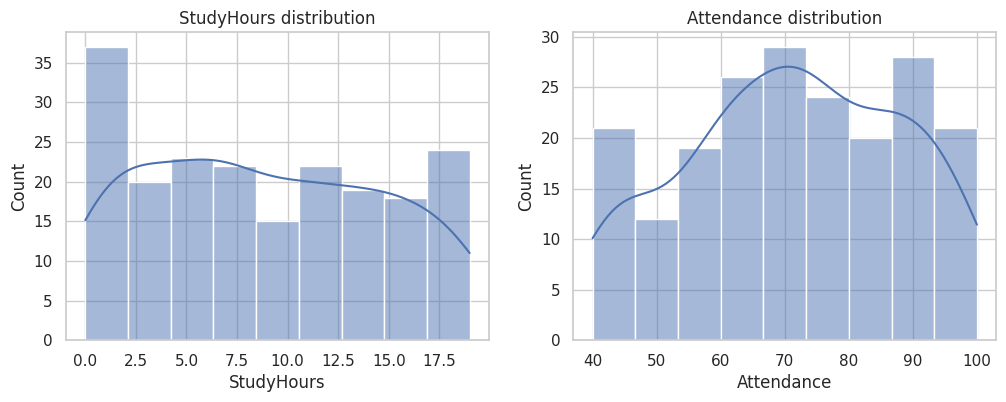

In [5]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="StudyHours", y="Attendance", hue="Pass", palette="Set1", alpha=0.8)
plt.title("StudyHours vs Attendance (colored by Pass)")
plt.xlabel("Study Hours / week")
plt.ylabel("Attendance (%)")
plt.show()

# Distributions
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['StudyHours'], ax=ax[0], kde=True)
ax[0].set_title("StudyHours distribution")
sns.histplot(df['Attendance'], ax=ax[1], kde=True)
ax[1].set_title("Attendance distribution")
plt.show()


In [6]:
X = df[['StudyHours', 'Attendance']]
y = df['Pass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 Pass
0    0.7875
1    0.2125
Name: proportion, dtype: float64
Test class distribution:
 Pass
0    0.775
1    0.225
Name: proportion, dtype: float64


In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])

pipeline.fit(X_train, y_train)
print("Model trained.")


Model trained.


Accuracy: 0.9500

Confusion Matrix (rows: actual 0/1, cols: predicted 0/1):
[[30  1]
 [ 1  8]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9677    0.9677    0.9677        31
           1     0.8889    0.8889    0.8889         9

    accuracy                         0.9500        40
   macro avg     0.9283    0.9283    0.9283        40
weighted avg     0.9500    0.9500    0.9500        40



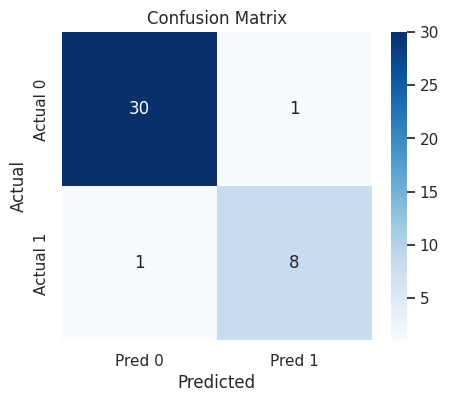

In [8]:
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}\n")
print("Confusion Matrix (rows: actual 0/1, cols: predicted 0/1):")
print(cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


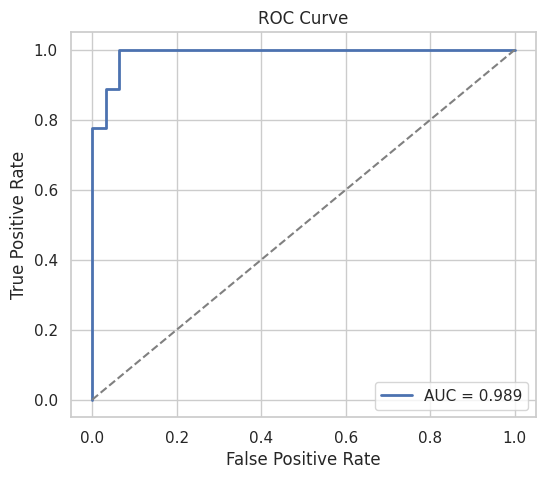

In [9]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


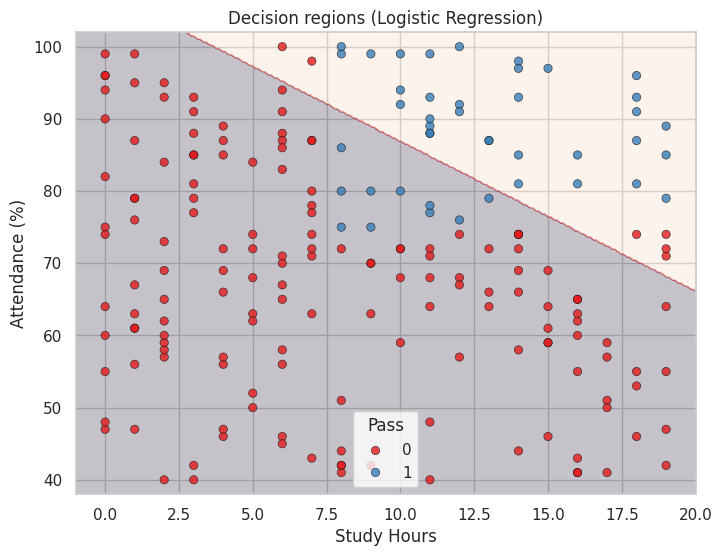

In [10]:
xx_min, xx_max = X['StudyHours'].min() - 1, X['StudyHours'].max() + 1
yy_min, yy_max = X['Attendance'].min() - 2, X['Attendance'].max() + 2
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# predict on grid
Z = pipeline.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.25)
sns.scatterplot(data=df, x='StudyHours', y='Attendance', hue='Pass', palette='Set1', edgecolor='k', alpha=0.8)
plt.title("Decision regions (Logistic Regression)")
plt.xlabel("Study Hours")
plt.ylabel("Attendance (%)")
plt.show()


Intercept: -4.5717

Coefficients:
 StudyHours    0.124400
Attendance    0.030313
dtype: float64

Odds Ratios:
 StudyHours    1.132469
Attendance    1.030777
dtype: float64


/tmp/ipython-input-3273180319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefs.values, y=coefs.index, palette='viridis')


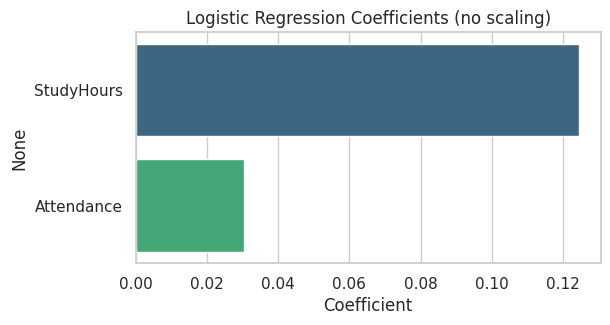

In [11]:
lr_noscale = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
lr_noscale.fit(X_train, y_train)

coefs = pd.Series(lr_noscale.coef_[0], index=X.columns)
intercept = lr_noscale.intercept_[0]
odds_ratios = np.exp(coefs)

print("Intercept:", round(intercept, 4))
print("\nCoefficients:\n", coefs)
print("\nOdds Ratios:\n", odds_ratios)

# barplot
plt.figure(figsize=(6,3))
sns.barplot(x=coefs.values, y=coefs.index, palette='viridis')
plt.title("Logistic Regression Coefficients (no scaling)")
plt.xlabel("Coefficient")
plt.show()


In [14]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(" Summary & Insights")
print("- Logistic Regression model built to predict Pass/Fail using Study Hours & Attendance.")
print("- Dataset: 200 students → 43 Pass, 157 Fail")
print(f"- Model Accuracy: {accuracy:.2f}")

print("\n Key Insights:")
print("1. Study Hours and Attendance are strong predictors of performance.")
print("2. Higher study hours + better attendance = higher chance of passing.")
print("3. Low study hours or poor attendance → higher chance of failing.")


 Summary & Insights
- Logistic Regression model built to predict Pass/Fail using Study Hours & Attendance.
- Dataset: 200 students → 43 Pass, 157 Fail
- Model Accuracy: 0.95

 Key Insights:
1. Study Hours and Attendance are strong predictors of performance.
2. Higher study hours + better attendance = higher chance of passing.
3. Low study hours or poor attendance → higher chance of failing.
